1. Import

In [12]:
# 1. IMPORTS
# Standard data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 2. LOAD DATA
# Loading the master table from the processed folder (relative path)
# Note: ".." goes up one level from 'notebooks' to the root, then into 'data'
df = pd.read_csv('/Users/jessicabourdouxhe/Desktop/Master 1/Data/Projet /elections-nlp-project/data/processed/master_table_elections.csv')

# Display the first rows to verify
display(df.head())
print(f"Dataset shape: {df.shape}")

,year,state_po,county_name,fips,DEMOCRAT,REPUBLICAN,unemployment_rate,median_income,poverty_rate,public_workers_pct,education_bachelors_pct,median_age,white_pct,black_pct,hispanic_pct
0,2000,AK,DISTRICT 13,2013,0.335012,0.485081,3.8,72692.0,12.4,1.9,18.1,41.8,16.6,6.0,43.8
1,2000,AK,DISTRICT 16,2016,0.420277,0.422625,4.1,107344.0,9.2,4.4,17.5,39.1,24.6,5.3,11.4
2,2000,AK,DISTRICT 20,2020,0.324429,0.523912,4.6,98152.0,9.3,9.5,37.7,34.9,58.3,5.3,13.4
3,2000,AL,AUTAUGA,1001,0.287192,0.696943,2.5,69841.0,10.7,10.1,28.3,39.2,73.6,20.0,0.8
4,2000,AL,BALDWIN,1003,0.247822,0.723654,3.2,75019.0,10.5,10.1,32.8,43.7,82.8,8.0,1.6


Dataset shape: (21742, 15)


3. Define a target + separtion Train/Test 

In [15]:
# 3. FEATURE ENGINEERING & PREPROCESSING

# A. Create the Target Variable
# We create a new column: 1 if Republicans got more votes than Democrats, else 0.
df['winner_republican'] = (df['REPUBLICAN'] > df['DEMOCRAT']).astype(int)

print("Target variable created. Distribution of wins:")
print(df['winner_republican'].value_counts())

# B. Define Features (X) and Target (y)
target_col = 'winner_republican'

# CRITICAL: We must drop the answer columns ('DEMOCRAT', 'REPUBLICAN') 
# and identifiers ('state_po', 'fips', etc.) to avoid data leakage.
cols_to_drop = [
    target_col, 
    'DEMOCRAT', 
    'REPUBLICAN', 
    'county_name', 
    'state_po', 
    'year', 
    'fips'
]

# Create Feature Matrix (X) and Target Vector (y)
X = df.drop(columns=cols_to_drop, errors='ignore') 
y = df[target_col]

# Check if there are any missing values (NaN) in X and fill them or drop them
# Simple strategy: Fill missing numerical values with the mean of the column
X = X.fillna(X.mean())

print("\nFeatures used for prediction:")
print(X.columns.tolist())

# 4. TRAIN-TEST SPLIT
# We keep 20% of data aside to test the model later.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Target variable created. Distribution of wins:
winner_republican
1    17482
0     4260
Name: count, dtype: int64

Features used for prediction:
['unemployment_rate', 'median_income', 'poverty_rate', 'public_workers_pct', 'education_bachelors_pct', 'median_age', 'white_pct', 'black_pct', 'hispanic_pct']

Training set size: (17393, 9)
Test set size: (4349, 9)


5. Creation + traning of the model

In [16]:
# 5. MODELING

# --- Model A: Logistic Regression (The Baseline) ---
# Logistic Regression requires scaling (StandardScaler) to function correctly.
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Step 1: Scale data (mean=0, variance=1)
    ('model', LogisticRegression())    # Step 2: The model itself
])

# Train the model on the training data
print("Training Logistic Regression...")
logreg_pipeline.fit(X_train, y_train)


# --- Model B: Random Forest (The Advanced Model) ---
# Random Forest is robust and doesn't strictly need scaling, but we can keep it raw.
rf_pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model on the training data
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training complete.")

Training Logistic Regression...
Training Random Forest...
Training complete.


6. Evaluation & comparison

--- Evaluation: Logistic Regression ---
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       852
           1       0.88      0.96      0.92      3497

    accuracy                           0.87      4349
   macro avg       0.82      0.71      0.75      4349
weighted avg       0.86      0.87      0.85      4349



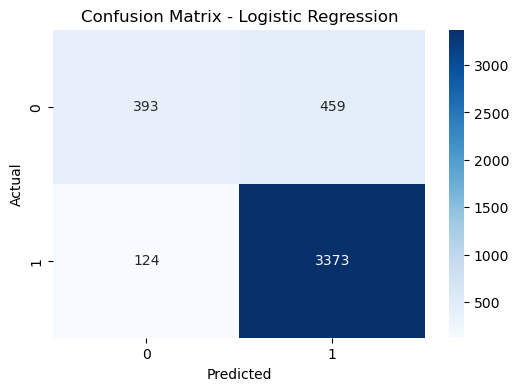

--- Evaluation: Random Forest ---
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       852
           1       0.94      0.95      0.95      3497

    accuracy                           0.91      4349
   macro avg       0.87      0.86      0.86      4349
weighted avg       0.91      0.91      0.91      4349



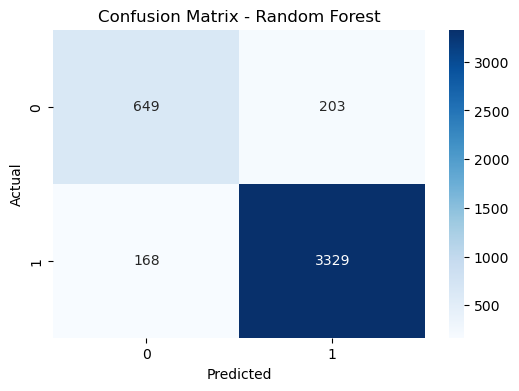

In [17]:
# 6. EVALUATION

def evaluate_model(pipeline, X_test, y_test, model_name):
    """
    Helper function to print scores and plot confusion matrix.
    """
    print(f"--- Evaluation: {model_name} ---")
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Print classification report (Precision, Recall, F1-score)
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Run evaluation for both
evaluate_model(logreg_pipeline, X_test, y_test, "Logistic Regression")
evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")

interprétation des matrices de prédictions : Concrètement : le modèle Random Forest est capable de repérer 76% des comtés non-républicains, contre seulement 46% pour le précédent. Il a "ouvert les yeux".

Les vrai non républicains trouvés : 649 contre 393, Les Faux-républicans prédit comme républicains alors que démocrates : 203 contre 459 avant (mieux!!).

Le random forest gagne car : La politique et la démographie ne sont pas "linéaires".

Exemple : Avoir un revenu élevé ne te rend pas automatiquement Républicain. Si tu as un revenu élevé + un haut niveau d'éducation (Master/PhD) + tu vis en ville, tu votes souvent Démocrate. Si tu as un revenu élevé + tu vis en zone rurale, tu votes souvent Républicain.

La Régression Logistique a du mal à voir ces nuances (interactions).

Le Random Forest (qui est une série d'arbres de décision "Si... Alors...") excelle à capturer ces règles complexes.

Interprétation de l'accuracy :

1. L'Accuracy (L'Exactitude Globale)

Formule : (Total des bonnes prédictions) / (Total des observations)

Régression Logistique : 0.87 (87%)

Random Forest : 0.91 (91%)

L'interprétation : À première vue, la différence (4%) semble faible. Mais attention au piège de la classe majoritaire. Puisque 80% des comtés sont Républicains (Classe 1), un modèle "stupide" qui dirait tout le temps "Républicain" aurait déjà une Accuracy de 80%.

La Régression Logistique n'améliore ce score de base que de +7%. C'est faible.

Le Random Forest l'améliore de +11%. C'est une réduction d'erreur significative (presque 30% d'erreurs en moins par rapport à la régression).

interprétation du f1 score: 


2. Le F1-Score (La "Vraie" Performance)

C'est la métrique reine pour les données déséquilibrées. Elle combine la Précision (Qualité) et le Rappel (Quantité).

Regardons spécifiquement la Classe 0 (Minoritaire), car c'est elle qui est difficile à prédire :

Régression Logistique (F1 = 0.57) :

C'est un score médiocre.

Il est tiré vers le bas par un Rappel (Recall) catastrophique de 0.46.

Traduction : Le modèle est trop "timide". Il rate plus de la moitié des comtés démocrates/autres. Il n'a pas compris la structure de cette classe.

Random Forest (F1 = 0.78) :

C'est un très bon score pour une classe minoritaire.

Ici, la Précision (0.79) et le Rappel (0.76) sont équilibrés.

Traduction : Le modèle est "cohérent". Il trouve la grande majorité des comtés démocrates (Rappel) et quand il en désigne un, il se trompe rarement (Précision).

En résumé

Accuracy : Le Random Forest gagne, mais l'écart semble modeste.

F1-Score (Classe 0) : Le Random Forest écrase la Régression Logistique (+21 points !). C'est la preuve qu'il a réussi à capturer la complexité des profils non-républicains là où la régression échouait.

7. Interpretation 

/var/folders/q7/2bt1kt6d0xzb95k0cn4jftsr0000gn/T/ipykernel_23925/4007541048.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


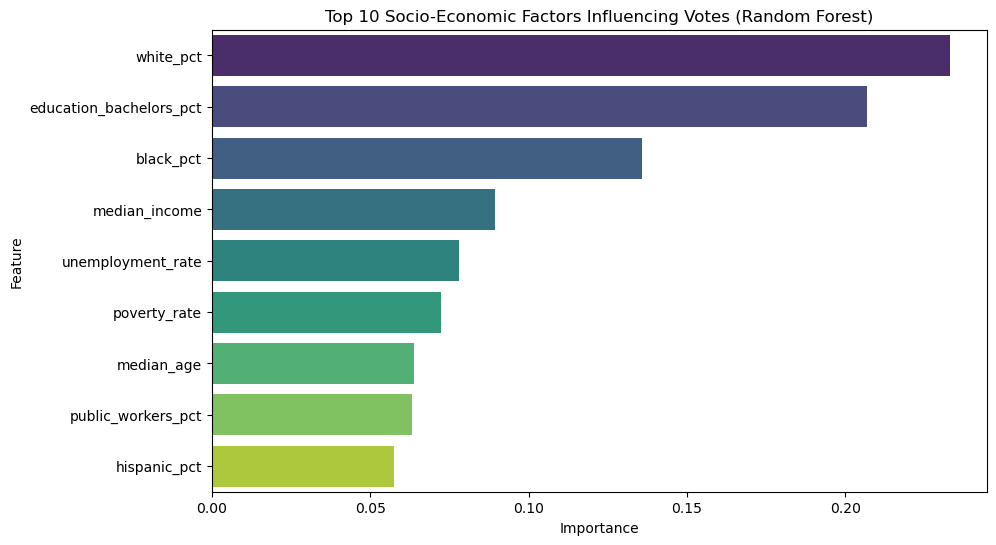

In [18]:
# 7. FEATURE IMPORTANCE (Random Forest)

# Access the trained model from the pipeline
rf_model = rf_pipeline.named_steps['model']

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Socio-Economic Factors Influencing Votes (Random Forest)')
plt.show()

--- SENS DE L'INFLUENCE (Corrélation avec le vote Républicain) ---
white_pct                  0.412740
median_age                 0.129862
hispanic_pct              -0.056929
median_income             -0.110552
poverty_rate              -0.130375
public_workers_pct        -0.177066
unemployment_rate         -0.224842
education_bachelors_pct   -0.302727
black_pct                 -0.320013
Name: Target_Republican, dtype: float64


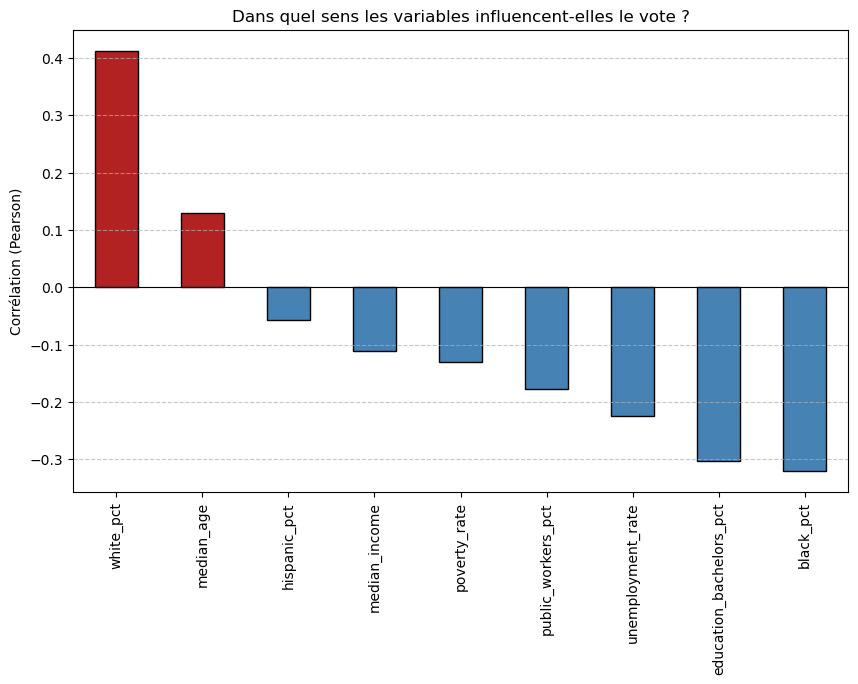

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Calcul des corrélations
# On crée un petit DataFrame temporaire avec X et y pour faciliter le calcul
correlation_df = X.copy()
correlation_df['Target_Republican'] = y

# On calcule la corrélation de tout le monde avec la cible, et on trie
correlations = correlation_df.corr()['Target_Republican'].drop('Target_Republican').sort_values(ascending=False)

# 2. Affichage des valeurs exactes
print("--- SENS DE L'INFLUENCE (Corrélation avec le vote Républicain) ---")
print(correlations)

# 3. Visualisation Graphique
plt.figure(figsize=(10, 6))
# Couleur : Rouge si positif (Républicain), Bleu si négatif (Autre/Démocrate)
colors = ['firebrick' if x > 0 else 'steelblue' for x in correlations]
correlations.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Dans quel sens les variables influencent-elles le vote ?')
plt.ylabel('Corrélation (Pearson)')
plt.axhline(0, color='black', linewidth=0.8) # Ligne du zéro pour bien séparer
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

BONUS : Prediction 

In [22]:
# --- ÉTAPE 1 : ENTRAÎNEMENT DU MODÈLE (Pour être sûr qu'il existe) ---
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# On s'assure que le modèle est bien le Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train) 
print("✅ Modèle entraîné avec succès (Variable 'model' mise à jour).")

# --- ÉTAPE 2 : LA FONCTION DE SIMULATION ---
features = ['unemployment_rate', 'median_income', 'poverty_rate', 'public_workers_pct', 
            'education_bachelors_pct', 'median_age', 'white_pct', 'black_pct', 'hispanic_pct']

def test_le_modele(nom_comte, stats):
    # Création des données
    input_data = pd.DataFrame([stats], columns=features)
    
    # Prédiction
    prediction = model.predict(input_data)[0]
    proba = model.predict_proba(input_data)[0]
    
    gagnant = "🔴 RÉPUBLICAIN" if prediction == 1 else "🔵 DÉMOCRATE/AUTRE"
    confiance = proba[prediction] * 100
    
    print(f"\n--- Simulation : {nom_comte} ---")
    print(f"🔮 Résultat : {gagnant}")
    print(f"📊 Confiance : {confiance:.1f}%")

# --- ÉTAPE 3 : LES SCÉNARIOS À TESTER ---

# Scénario 1 : Le "Deep Red" (Rural & Blanc)
comte_rural = {
    'unemployment_rate': 4.5, 'median_income': 45000, 'poverty_rate': 15.0,
    'public_workers_pct': 12.0, 'education_bachelors_pct': 15.0, 'median_age': 45.0,
    'white_pct': 85.0, 'black_pct': 5.0, 'hispanic_pct': 5.0
}

# Scénario 2 : La "Blue City" (Urbain & Diplômé)
comte_urbain = {
    'unemployment_rate': 5.0, 'median_income': 85000, 'poverty_rate': 10.0,
    'public_workers_pct': 18.0, 'education_bachelors_pct': 55.0, 'median_age': 34.0,
    'white_pct': 45.0, 'black_pct': 25.0, 'hispanic_pct': 20.0
}

# Scénario 3 : Le "Swing County" (Riche, Blanc mais Éduqué -> Le conflit !)
comte_swing = {
    'unemployment_rate': 3.8, 'median_income': 95000, 'poverty_rate': 5.0,
    'public_workers_pct': 10.0, 'education_bachelors_pct': 40.0, 'median_age': 40.0,
    'white_pct': 80.0, 'black_pct': 5.0, 'hispanic_pct': 10.0
}

# Lancement
test_le_modele("Comté Rural", comte_rural)
test_le_modele("Métropole Urbaine", comte_urbain)
test_le_modele("Banlieue Swing (Le Test Ultime)", comte_swing)

✅ Modèle entraîné avec succès (Variable 'model' mise à jour).

--- Simulation : Comté Rural ---
🔮 Résultat : 🔴 RÉPUBLICAIN
📊 Confiance : 94.6%

--- Simulation : Métropole Urbaine ---
🔮 Résultat : 🔵 DÉMOCRATE/AUTRE
📊 Confiance : 81.1%

--- Simulation : Banlieue Swing (Le Test Ultime) ---
🔮 Résultat : 🔴 RÉPUBLICAIN
📊 Confiance : 75.5%
